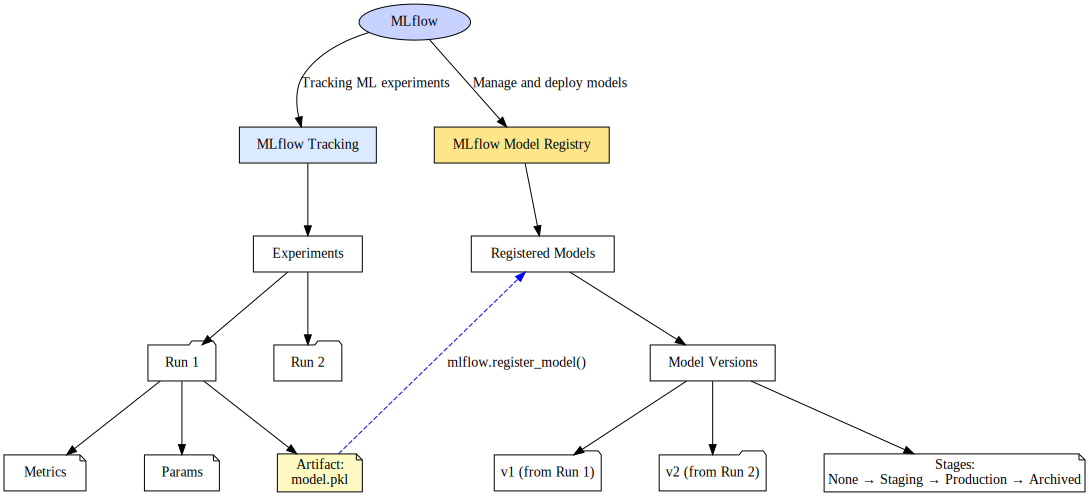

In [7]:
from graphviz import Digraph

dot = Digraph("MLflow_Structure", format="png")
dot.attr(rankdir="TB", splines="spline", nodesep="0.8", ranksep="1.0", bgcolor="white")

# Root
dot.node("mlflow", "🚀 MLflow", shape="oval", style="filled", fillcolor="#c7d2fe")

# Left: Tracking
dot.node("tracking", "📊 MLflow Tracking", shape="box", style="filled", fillcolor="#dbeafe")
dot.node("exp", "🗂️ Experiments", shape="box")
dot.node("run1", "▶️ Run 1", shape="folder", style="rounded")
dot.node("run2", "▶️ Run 2", shape="folder", style="rounded")

# Run 1 internals
dot.node("metrics1", "📈 Metrics", shape="note")
dot.node("params1", "⚙️ Params", shape="note")
dot.node("artifact1", "📁 Artifact:\nmodel.pkl", shape="note", style="filled", fillcolor="#fef9c3")

# Right: Model Registry
dot.node("registry", "📦 MLflow Model Registry", shape="box", style="filled", fillcolor="#fde68a")
dot.node("reg_models", "🗃️ Registered Models", shape="box")
dot.node("versions", "🔢 Model Versions", shape="box")
dot.node("v1", "v1 (from Run 1)", shape="folder", style="rounded")
dot.node("v2", "v2 (from Run 2)", shape="folder", style="rounded")
dot.node("stages", "⛓️ Stages:\nNone → Staging → Production → Archived", shape="note")

# Top-level connections
dot.edge("mlflow", "tracking", label="Tracking ML experiments")
dot.edge("mlflow", "registry", label="Manage and deploy models")

# Left branch connections
dot.edge("tracking", "exp")
dot.edge("exp", "run1")
dot.edge("exp", "run2")
dot.edge("run1", "metrics1")
dot.edge("run1", "params1")
dot.edge("run1", "artifact1")

# Artifact connects to Registry
dot.edge("artifact1", "reg_models", label="mlflow.register_model()", style="dashed", color="blue",constraint="false")

# Right branch connections
dot.edge("registry", "reg_models")
dot.edge("reg_models", "versions")
dot.edge("versions", "v1")
dot.edge("versions", "v2")
dot.edge("versions", "stages")

dot


In [ ]:
!pip install mlflow==2.14.1
!pip install pyngrok


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

mlflow_dir = "/content/drive/MyDrive/Colab Notebooks/ML_flow/mlflow_runs"  # pick your folder


Mounted at /content/drive


In [ ]:
# Kill old servers
!pkill -f mlflow

# Start MLflow UI/Server with Google Drive as backend store
!nohup mlflow ui \
  --backend-store-uri "file:/content/drive/MyDrive/Colab Notebooks/ML_flow/mlflow_runs" \
  --default-artifact-root "file:/content/drive/MyDrive/Colab Notebooks/ML_flow/mlflow_runs" \
  --host 0.0.0.0 --port 5000 > mlflow_ui.log 2>&1 &


In [ ]:
from pyngrok import ngrok

# Use your ngrok auth token
ngrok.set_auth_token("35UdMRWoqMHpNBmwoFdo6zUaxGI_3FKaBqxG7Adjt5KJgzLSc")

# Expose MLflow port 5000
public_url = ngrok.connect(5000)
public_url

#mlflow.set_tracking_uri(public_url.public_url)


<NgrokTunnel: "https://ungoaded-dustin-unmimicked.ngrok-free.dev" -> "http://localhost:5000">

In [ ]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")   # local HTTP is enough
# OR if you really want, you *can* use public_url.public_url, but not needed
# mlflow.set_tracking_uri(public_url.public_url)


| Color            | Meaning                                                 |
| ---------------- | ------------------------------------------------------- |
| **🔴 Red**       | Run completed normally but did NOT log a model artifact |
| **🟢 Green**     | Run logged a model artifact                             |
| **⚠️ Yellow**    | Appears only when run is *active* (running right now)   |
| **❌ Error icon** | Only appears if exceptions happened                     |


In [ ]:
import mlflow
from datetime import date
from dateutil.relativedelta import relativedelta
import pprint
import pandas_datareader
import pandas
import requests

import pandas_datareader.data as web
from scipy.stats import entropy

import os
import mlflow
import numpy as np
import pandas as pd



# 1). Data and Feature Management

## 1.1. bronze-load_raw_data.py

In [ ]:
mlflow.set_experiment("raw_data_ingestion")


2025/11/17 21:29:07 INFO mlflow.tracking.fluent: Experiment with name 'raw_data_ingestion' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///content/drive/MyDrive/Colab '
 'Notebooks/ML_flow/mlflow_runs/999616519092735634'), creation_time=1763414947254, experiment_id='999616519092735634', last_update_time=1763414947254, lifecycle_stage='active', name='raw_data_ingestion', tags={}>

In [ ]:
# load_raw_data.py

import mlflow
import os
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import yfinance as yf

RAW_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_flow/data/raw/"
os.makedirs(RAW_PATH, exist_ok=True)


def safe_today():
    system_date = datetime.utcnow().date()
    real_today = date.today()

    # If system time is ahead (common on some VMs), use real_today
    if system_date > real_today:
        return real_today
    return system_date



# ---------------------------
# Load Data & Log
# ---------------------------
with mlflow.start_run(run_name="load_raw_data") as run:

    mlflow.set_tag("stage", "bronze")
    mlflow.set_tag("source", "Yahoo Finance via yfinance")
    mlflow.set_tag("asset", "BTC-USD")

    # Date range: past 3 months
    end = safe_today()
    start = end - relativedelta(months=3)

    print(f"Downloading BTC-USD from {start} to {end} ...")

    # Download using yfinance (reliable)
    df = yf.download("BTC-USD", start=start, end=end)

    # Log shape
    mlflow.log_metric("raw_row_count", len(df))
    mlflow.log_metric("raw_col_count", df.shape[1])

    # Save CSV
    save_path = f"{RAW_PATH}/data.csv"
    df.to_csv(save_path)

    # Log as MLflow artifact
    mlflow.log_artifact(save_path)
    print(f"MLflow Experiment ID: {run.info.experiment_id}")
    print(f"Raw data saved to: {save_path}")
    print(f"MLflow run ID: {run.info.run_id}")


/tmp/ipython-input-4244930487.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  system_date = datetime.utcnow().date()
/tmp/ipython-input-4244930487.py:40: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", start=start, end=end)
[*********************100%***********************]  1 of 1 completed

MLflow Experiment ID: 999616519092735634
Raw data saved to: /content/drive/MyDrive/Colab Notebooks/ML_flow/data/raw//data.csv
MLflow run ID: 8572ba4e79d7405cbe52149e61f855fa


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 1.2. check_verify_data

In [ ]:
# check_verify_data.py

import mlflow
import os
import pandas as pd
import great_expectations as ge


In [ ]:
import mlflow
import os
import pandas as pd
import great_expectations as ge


STAGING_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_flow/data/staging"
os.makedirs(STAGING_PATH, exist_ok=True)


def assert_type(df, col, dtype):
    if df[col].dtype != dtype:
        raise ValueError(f"Column {col} expected {dtype}, got {df[col].dtype}")



In [ ]:
# check_verify_data.py

import mlflow
import os
import pandas as pd
import great_expectations as ge


STAGING_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_flow/data/staging"
os.makedirs(STAGING_PATH, exist_ok=True)


def assert_type(df, col, dtype):
    if df[col].dtype != dtype:
        raise ValueError(f"Column {col} expected {dtype}, got {df[col].dtype}")



with mlflow.start_run(run_name="check_verify_data") as run:

    mlflow.set_tag("stage", "silver")
    mlflow.set_tag("task", "data_validation")

    # Load Bronze data

    # ---------------------------
    # 1. Load raw CSV
    # ---------------------------
    df_raw = pd.read_csv(RAW_PATH+"/data.csv")

    # Your raw file has TWO header rows (Ticker, Date, BTC-USD)
    # We drop those rows
    df = df_raw.iloc[2:].reset_index(drop=True)

    # Rename the first column to "Date"
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)

    # ---------------------------
    # 2. Convert data types
    # ---------------------------
    # Convert Date to datetime
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    # Auto-detect numeric columns (everything except Date)
    numeric_cols = df.drop(columns=["Date"], errors="ignore").columns.tolist()

    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")


    # -----------------------------------
    # SIMPLE DATA VALIDATION (RECOMMENDED)
    # -----------------------------------

    # Expected numeric columns
    numeric_cols = ["Open", "High", "Low", "Close", "Volume"] # 'Adj Close' is often not present for crypto data

    # Explicitly convert numeric columns to float, coercing errors
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    for col in numeric_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

        if not pd.api.types.is_numeric_dtype(df[col]):
            # This check should now pass if conversion was successful
            raise TypeError(f"Column {col} must be numeric after conversion")

        if df[col].isnull().mean() > 0.2:
            raise ValueError(f"Too many nulls in column: {col}")

    # Check date column
    if "Date" in df.columns:
        try:
            df["Date"] = pd.to_datetime(df["Date"])
        except:
            raise ValueError("Invalid Date format")

    mlflow.log_metric("validation_success", 1)

    # -----------------------------------
    # Cleaning (simple)
    # -----------------------------------
    df_clean = df.dropna()
    mlflow.log_metric("cleaned_row_count", len(df_clean))

    # Save staged data
    save_path = f"{STAGING_PATH}/data.csv"
    df_clean.to_csv(save_path, index=False)
    mlflow.log_artifact(save_path)

    print("Staged data saved to:", save_path)

Staged data saved to: /content/drive/MyDrive/Colab Notebooks/ML_flow/data/staging/data.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 1.3. Gold- feature_set_generation

In [ ]:
TRAINING_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_flow/data/training"
os.makedirs(TRAINING_PATH, exist_ok=True)

# -------------------------------------
# Rolling window implementation
# (template from the book — unchanged)
# -------------------------------------
def rolling_window(a, window):
    """
    Takes np.array 'a' and size 'window'
    Returns np.array of ordered sequences of size 'window'

    Example:
    a = [1,2,3,4,5,6], window=4
    → [[1,2,3,4],
       [2,3,4,5],
       [3,4,5,6]]
    """
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [ ]:
with mlflow.start_run(run_name="generate_feature_set") as run:

    # Metadata
    mlflow.set_tag("stage", "gold")
    mlflow.set_tag("description", "Generate windowed feature dataset")

    # Create training directory if it doesn't exist


    # -------------------------------------
    # 1. Load cleaned data
    # -------------------------------------
    df = pd.read_csv(STAGING_PATH+"/data.csv")

    # Log input data dimensions
    mlflow.log_metric("staging_rows", len(df))
    mlflow.log_metric("staging_cols", len(df.columns))

    # -------------------------------------
    # 2. Feature Engineering
    # -------------------------------------
    # Price movement label
    df["delta_pct"] = (df["Close"] - df["Open"]) / df["Open"]
    df["going_up"] = df["delta_pct"].apply(lambda d: 1 if d > 0.00001 else 0)

    # Log class counts
    up_count = df["going_up"].sum()
    down_count = len(df) - up_count
    mlflow.log_metric("label_up_count", up_count)
    mlflow.log_metric("label_down_count", down_count)

    # Convert label column to numpy
    series = df["going_up"].to_numpy()

    # Window size
    WINDOW_SIZE = 15
    mlflow.log_param("window_size", WINDOW_SIZE)

    # -------------------------------------
    # 3. Generate rolling window training data
    # -------------------------------------
    training_data = rolling_window(series, WINDOW_SIZE)

    # Log number of samples produced
    mlflow.log_metric("training_samples", len(training_data))


    # (a) Sum inside each window (number of upward movements)
    window_sums = training_data.sum(axis=1)
    mlflow.log_metric("window_avg_sum", window_sums.mean())
    mlflow.log_metric("window_min_sum", window_sums.min())
    mlflow.log_metric("window_max_sum", window_sums.max())
    mlflow.log_metric("window_std_sum", window_sums.std())

    # (b) Proportion of 1’s inside windows
    prop_up = window_sums / WINDOW_SIZE
    mlflow.log_metric("window_avg_up_ratio", prop_up.mean())

    # (c) Transition dynamics
    diffs = np.diff(training_data, axis=1)   # shape: (N, WINDOW_SIZE-1)
    up_jumps = (diffs == 1).sum()
    down_jumps = (diffs == -1).sum()

    mlflow.log_metric("transitions_up", int(up_jumps))
    mlflow.log_metric("transitions_down", int(down_jumps))
    mlflow.log_metric("transition_ratio_up_down",
                      float(up_jumps / max(1, down_jumps)))

    # (d) Entropy per window (complexity measure)
    window_entropy = [entropy([p, 1-p]) for p in prop_up]
    mlflow.log_metric("window_avg_entropy", float(np.mean(window_entropy)))



    # -------------------------------------
    # 4. Save Gold Training dataset
    # -------------------------------------
    save_path = f"{TRAINING_PATH}/data.csv"
    pd.DataFrame(training_data).to_csv(save_path, index=False)

    # Log artifact
    mlflow.log_artifact(save_path)

    print("Training data generated:", save_path)
    print("MLflow Run ID:", run.info.run_id)

Training data generated: /content/drive/MyDrive/Colab Notebooks/ML_flow/data/training/data.csv
MLflow Run ID: 7e1a673dedf14c27ac02979dc1f8978f


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
training_data

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 1, 0, ..., 0, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 0]])

# 2). Training Models with MLflow

In [ ]:
import os

PREDICTION_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_flow/data/predictions"
os.makedirs(PREDICTION_PATH, exist_ok=True)


## 2.1. Implementing the training job

In [ ]:
import pandas as pd
import mlflow
import xgboost as xgb
import mlflow.xgboost
from sklearn.model_selection import train_test_split

def train_test_split_pandas(pandas_df,t_size=0.33,r_tate=42):
    X=pandas_df.iloc[:,:-1]
    Y=pandas_df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=t_size, random_state=r_tate)

    return X_train, X_test, y_train, y_test



THRESHOLD = 0.5

mlflow.xgboost.autolog()
with mlflow.start_run(run_name="train_model") as run:
    mlflow.set_tag("mlflow.runName", "train_model")

    pandas_df=pd.read_csv(f"{TRAINING_PATH}/data.csv", header=None)

    X_train, X_test, y_train, y_test = train_test_split_pandas(pandas_df)

    train_data = xgb.DMatrix(X_train, label=y_train)
    test_data =  xgb.DMatrix(X_test)

    model = xgb.train(dtrain=train_data,params={})

    y_probas=model.predict(test_data)
    y_preds = [1 if  y_proba > THRESHOLD else 0 for y_proba in y_probas]

    test_prediction_results = pd.DataFrame(data={'y_pred':y_preds,'y_test':y_test})

    result = test_prediction_results

    # Use the defined PREDICTION_PATH
    prediction_file_path = f"{PREDICTION_PATH}/test_predictions.csv"
    result.to_csv(prediction_file_path)
    mlflow.log_artifact(prediction_file_path)

2025/11/17 23:56:48 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2025/11/17 23:56:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/la

## 2.2. Evaluating the model

In [ ]:
import pandas as pd
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import  \
    classification_report, \
    confusion_matrix, \
    accuracy_score, \
    auc, \
    average_precision_score, \
    balanced_accuracy_score, \
    f1_score, \
    fbeta_score, \
    hamming_loss, \
    jaccard_score, \
    log_loss, \
    matthews_corrcoef, \
    precision_score, \
    recall_score, \
    zero_one_loss

def clean_classification_df(df):
    """
    Fixes y_pred and y_test for classification metrics.
    Ensures:
        - both columns are numeric
        - both columns are integers
        - both columns are binary (0/1)
    """
    # Convert to numeric
    df["y_pred"] = pd.to_numeric(df["y_pred"], errors="coerce")
    df["y_test"] = pd.to_numeric(df["y_test"], errors="coerce")

    # Round predictions and convert to int
    df["y_pred"] = df["y_pred"].round().astype(int)

    # Fix labels: anything > 1 becomes 1, anything < 0 becomes 0
    df["y_test"] = df["y_test"].clip(lower=0, upper=1).astype(int)

    return df


def classification_metrics(df:None):
    metrics={}
    metrics["accuracy_score"]=accuracy_score(df["y_pred"], df["y_test"]  )
    metrics["average_precision_score"]=average_precision_score( df["y_pred"], df["y_test"]  )
    metrics["f1_score"]=f1_score( df["y_pred"], df["y_test"]  )
    metrics["jaccard_score"]=jaccard_score( df["y_pred"], df["y_test"]  )
    metrics["log_loss"]=log_loss( df["y_pred"], df["y_test"]  )
    metrics["matthews_corrcoef"]=matthews_corrcoef( df["y_pred"], df["y_test"]  )
    metrics["precision_score"]=precision_score( df["y_pred"], df["y_test"]  )
    metrics["recall_score"]=recall_score( df["y_pred"], df["y_test"]  )
    metrics["zero_one_loss"]=zero_one_loss( df["y_pred"], df["y_test"]  )
    return metrics

In [ ]:
with mlflow.start_run(run_name="evaluate_model") as run:
    mlflow.set_tag("mlflow.runName", "evaluate_model")
    df=pd.read_csv(f"{PREDICTION_PATH}/test_predictions.csv")
    df= clean_classification_df(df)
    metrics = classification_metrics(df)
    mlflow.log_metrics(metrics)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Comparing different models

### Tuning your model with hyperparameter optimization

## 2.3. Deploying the model in the Model Registry

MLflow encourages registering from inside or immediately after your training run.

In [ ]:
import mlflow

# Put your latest training RUN_ID here (manually or via automation)
RUN_ID = "e35d976fdad5404388af86813e92b240"
MODEL_NAME = "training-model-psystock"
MODEL_URI = f"runs:/{RUN_ID}/model"

mlflow.set_experiment("model_register_pipeline")

with mlflow.start_run(run_name="register_model") as run:

    mlflow.set_tag("stage", "register")
    mlflow.set_tag("source_run_id", RUN_ID)

    result = mlflow.register_model(
        model_uri=MODEL_URI,
        name=MODEL_NAME
    )

    print("Registered model:", result.name)
    print("Version:", result.version)


2025/11/18 00:41:21 INFO mlflow.tracking.fluent: Experiment with name 'model_register_pipeline' does not exist. Creating a new experiment.
Successfully registered model 'training-model-psystock'.
2025/11/18 00:41:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: training-model-psystock, version 1


Registered model: training-model-psystock
Version: 1


Created version '1' of model 'training-model-psystock'.


### Other registry strategy
- Auto-register only if model meets thresholds
```python
if f1 > 0.70 and accuracy > 0.60:
    mlflow.register_model(...)
else:
    print("Model rejected — does not meet performance threshold")

```

In [ ]:
import mlflow

mlflow_model = mlflow.pyfunc.load_model("models:/training-model-psystock/1")




/usr/local/lib/python3.12/dist-packages/mlflow/xgboost/__init__.py:299: UserWarning: [00:59:38] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `xgb`. Using UBJSON (`ubj`) as a guess.
  model.load_model(xgb_model_path)


# 3). Monitoring data drift and model performance

## 3.1. Monitoring data drift

- drift library (like Evidently) to compute drift
- use MLflow to track + store those drift reports and metrics over time

In [ ]:
import pandas as pd

# Corrected URL for the raw CSV content
url = "https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/master/Chapter11/model_performance_drifts/training_data.csv"

reference_data = pd.read_csv(url,
    header=None,
    names=[ "day{}".format(i) for i in range(0,14) ] )

url = "https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/master/Chapter11/model_performance_drifts/to_score_input_data.csv"

latest_input_data = pd.read_csv(url,
    header=None,
    names=[ "day{}".format(i) for i in range(0,14) ] )

In [ ]:
pip install alibi-detect


In [ ]:
EXPERIMENT_NAME = "reports_data_drift"
mlflow.set_experiment(EXPERIMENT_NAME)

2025/11/18 03:25:58 INFO mlflow.tracking.fluent: Experiment with name 'reports_data_drift' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///content/drive/MyDrive/Colab '
 'Notebooks/ML_flow/mlflow_runs/563996555121758798'), creation_time=1763436359026, experiment_id='563996555121758798', last_update_time=1763436359026, lifecycle_stage='active', name='reports_data_drift', tags={}>

In [ ]:
from alibi_detect.cd import KSDrift
ref = reference_data.to_numpy()
new = latest_input_data.to_numpy()

cd = KSDrift(ref, p_val=0.05)
preds = cd.predict(new)   # dict with 'data' and 'meta'

In [ ]:
import os
EXPERIMENT_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_flow//reports_data_drift//"
os.makedirs(EXPERIMENT_PATH, exist_ok=True)


In [ ]:
import mlflow
import numpy as np
import pandas as pd
import json
import os

from alibi_detect.cd import KSDrift  # univariate drift detector
from alibi_detect.utils.saving import save_detector

with mlflow.start_run(run_name="alibi_data_drift"):

    mlflow.set_tag("stage", "drift_monitoring")
    mlflow.set_tag("drift_method", "alibi_ks")

    preds = cd.predict(new)

    # Quick summary metrics
    is_drift = int(preds["data"]["is_drift"])          # 0 or 1 (overall drift flag)
    p_vals = preds["data"]["p_val"]                    # list of length 14
    threshold = preds["data"]["threshold"]

    n_drifted_features = int(np.sum(np.array(p_vals) < threshold))
    share_drifted = n_drifted_features / len(p_vals)

    # Log metrics to MLflow
    mlflow.log_metric("is_drift", is_drift)
    mlflow.log_metric("n_drifted_features", n_drifted_features)
    mlflow.log_metric("share_drifted", share_drifted)

    # You can also log per-feature p-values if you like:
    for i, p in enumerate(p_vals):
        mlflow.log_metric(f"feature_day{i}_pvalue", float(p))



    # -------------------------
    # 6. Log folder to MLflow
    # -------------------------
    mlflow.log_artifacts(EXPERIMENT_PATH)

    print("Drift report saved and logged to MLflow.")


Drift report saved and logged to MLflow.


## 3.2. Monitoring target drift

## 3.3. Monitoring model drift

## 3.4. Infrastructure monitoring and alerting